In [1]:
import os
import sys
import pickle
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

from eval import get_metric_dataframes, get_prediction_and_ground_truths, eval_single_system
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
syn_cols = dataset.ratio_names+dataset.cond_names

df_zeos = pd.read_csv('data/zeolite_descriptors_for_dendro.csv').drop(columns=['Unnamed: 0'])

In [3]:
model_outputs = {}
for model_type, fname, split in [
                                # ('random', ['v0'], 'system'),
                                # ('amd', 'v0', 'system'),
                                # ('nn', ['v0'], 'system'),
                                # ('bnn', 'v0', 'system'),
                                # ('gmm', 'v0', 'system'),
                                # ('gan', 'v3', 'system'),
                                # ('nf', 'v0', 'system'),
                                # ('cvae', 'v10', 'system'),
                                ('diff', 'v3', 'system'),
                                ]:
    with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
        configs = json.load(f)

    if model_type == 'diff':
        syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, _ = get_prediction_and_ground_truths(_, configs, cond_scale=0.75)
    else:
        syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, _ = get_prediction_and_ground_truths(_, configs)

    model_outputs[model_type] = {'syn_pred': syn_pred, 'syn_pred_scaled': syn_pred_scaled, 'syn_true': syn_true, 'syn_true_scaled': syn_true_scaled}

Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


In [4]:
zeos = list(syn_true['zeo'].unique())
zeos.remove('Dense/Amorphous')

pred = model_outputs['diff']['syn_pred']
true = model_outputs['diff']['syn_true']

h2o_pred_means, h2o_pred_stds, h2o_preds = [], [], []
h2o_true_means, h2o_true_stds, h2o_trues = [], [], []
zeo_list = []
fwds = []

for zeo in zeos:
    h2o_pred = pred[pred['zeo']==zeo]
    h2o_true = true[true['zeo']==zeo]

    pred_true_ratio = len(h2o_pred) / len(h2o_true)

    h2o_true = h2o_true[
                    # (h2o_true['H2O/T'] > 0.)

                    # Fluoride synthesis
                    (h2o_true['F/T'] > 0.)

                    # No OH
                    & (h2o_true['OH/T'] == 0.)

                    # Non-AlPO
                    & ((h2o_true['Al/P'] < 0.5) | (h2o_true['Al/P'] > 1.5))

                    # Non-Ge
                    & (h2o_true['Si/Ge'] > 90.)

                    # Non-B
                    & (h2o_true['Si/B'] > 200.)

                    # High Si/Al
                    & (h2o_true['Si/Al'] > 30.)

                    # # No Na/K
                    # & (h2o_true['Na/T'] == 0.)
                    # & (h2o_true['K/T'] == 0.)
                    ]
    if len(h2o_true) > 0:
        true_idxs = h2o_true.index

        # Since predictions are stacked 50x that of true, we find the corresponding indices of predictions
        pred_idxs = np.concatenate(
                                        [np.arange(true_idx, true_idx+len(syn_true)*pred_true_ratio, len(syn_true)) for true_idx in true_idxs]
                                ).reshape(-1)

        h2o_pred = h2o_pred.loc[pred_idxs]

        h2o_pred = h2o_pred['H2O/T']
        h2o_true = h2o_true['H2O/T']

        fwd = df_zeos[df_zeos['iza']==zeo]['framework_density'].item()
        
        h2o_pred_means.append(h2o_pred.median())
        h2o_pred_stds.append(h2o_pred.std())
        h2o_preds.append(list(h2o_pred))
        h2o_true_means.append(h2o_true.median())
        h2o_true_stds.append(h2o_true.std())
        h2o_trues.append(list(h2o_true))
        zeo_list.append(zeo)
        fwds.append(fwd)
        
    else:
        continue

df_h2o_fwd = pd.DataFrame({'zeo': zeo_list, 'pred_mean': h2o_pred_means, 'pred_std': h2o_pred_stds, 'pred': h2o_preds, 'true_mean': h2o_true_means, 'true_std': h2o_true_stds, 'true': h2o_trues,'fwd': fwds})
df_h2o_fwd = df_h2o_fwd.sort_values('fwd')
df_h2o_fwd = df_h2o_fwd.dropna()

In [5]:
# for zeo in df_h2o_fwd['zeo']:
#     print(zeo)
#     plt.figure()
#     sns.histplot(df_h2o_fwd[df_h2o_fwd['zeo']==zeo]['pred'].item(), bins=50, binrange=[0, 50])
#     plt.show()

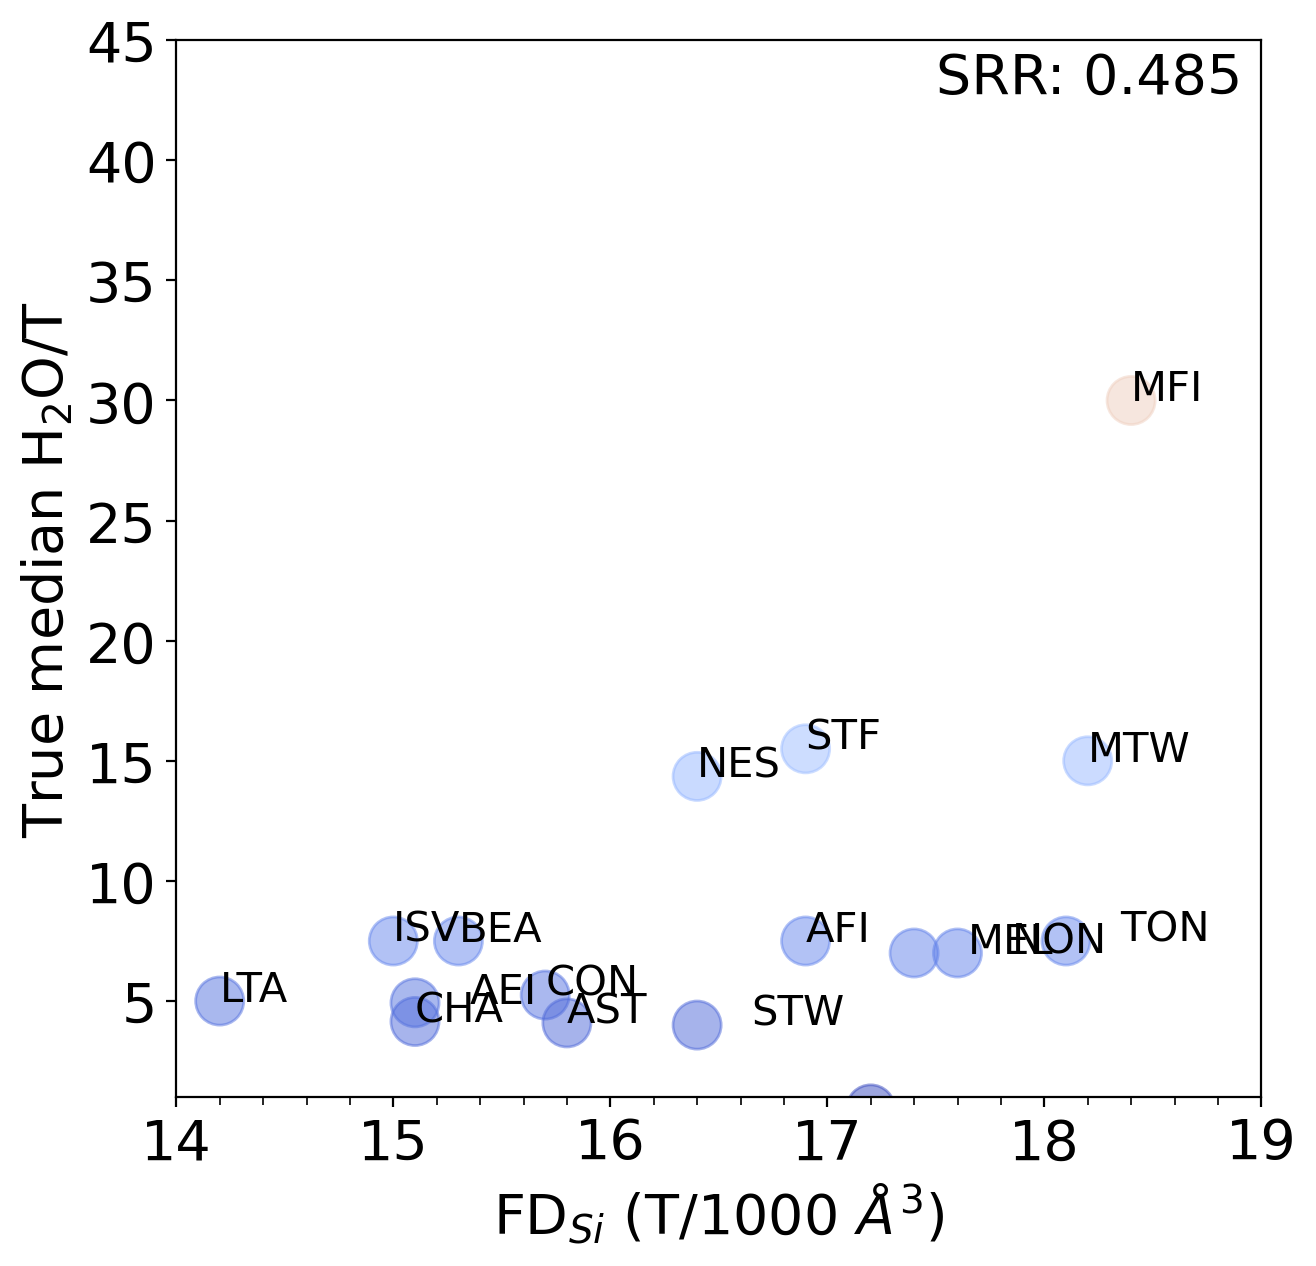

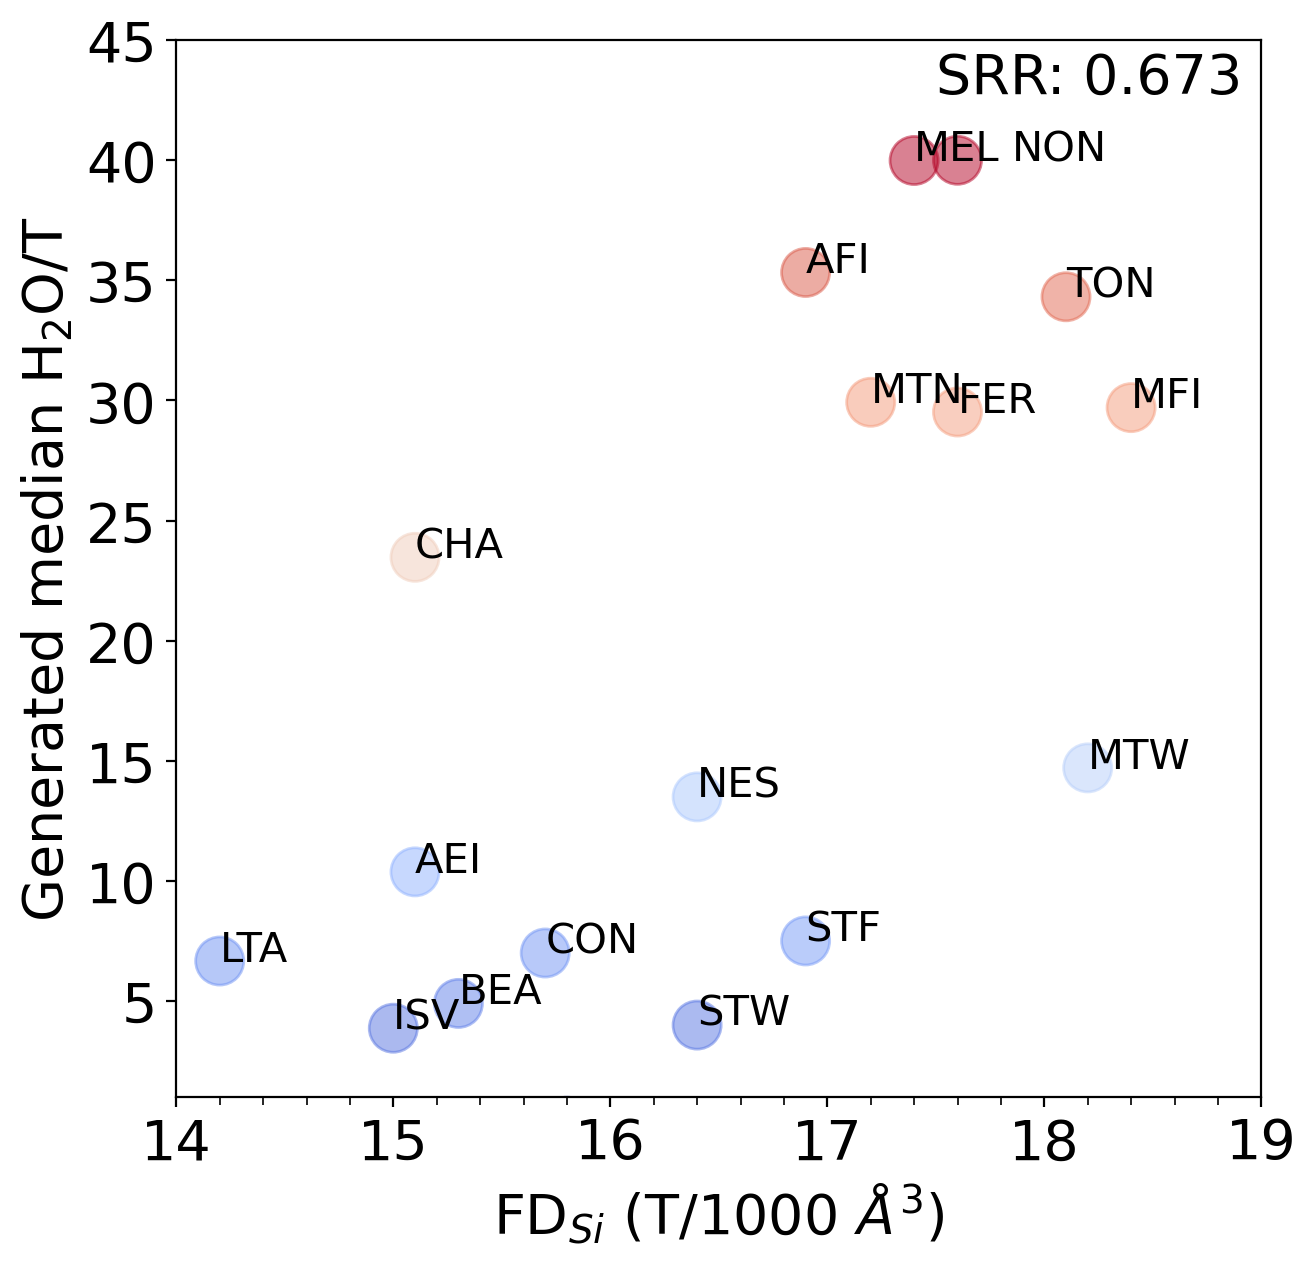

In [24]:
xlim = [14, 19]
ylim = [1, 45]
for i in ['true', 'pred']:
    fig, ax = plt.subplots(figsize=(7,7), dpi=200)
    plt.scatter(df_h2o_fwd['fwd'], df_h2o_fwd[f'{i}_mean'], marker='o', s=300, alpha = 0.5, c=df_h2o_fwd[f'{i}_mean'], cmap='coolwarm')
    # plt.errorbar(df_h2o_fwd['fwd'], df_h2o_fwd[f'{i}_mean'], yerr=df_h2o_fwd[f'{i}_std'], marker='o', alpha = 0.5, linestyle='None')
    plt.xlabel('FD$_{Si}$ (T/1000 $\AA^3$)', fontsize=20)
    if i == 'true':
        plt.ylabel('True median H$_{2}$O/T', fontsize=20)
    elif i == 'pred':
        plt.ylabel('Generated median H$_{2}$O/T', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    srr = round(spearmanr(df_h2o_fwd['fwd'], df_h2o_fwd[f'{i}_mean'])[0], 3)
    plt.text(0.7, 0.95, f'SRR: {srr}', fontsize=20, transform=ax.transAxes)
    xs, ys = [1e5], [1e5]
    dist_threshold = 1
    for zeo, x, y in zip(df_h2o_fwd['zeo'], df_h2o_fwd['fwd'], df_h2o_fwd[f'{i}_mean']):
        if xlim[0] < x < xlim[1] and ylim[0] < y < ylim[1]:
            dists = [np.sqrt((x-xs[-1])**2 + (y-ys[-1])**2) for xs, ys in zip([xs], [ys])]
            min_dist = min(dists)
            if min_dist < dist_threshold:
                x += 0.25
            
            xs.append(x), ys.append(y)
            plt.text(x, y, zeo, fontsize=15)

    plt.xlim(*xlim)
    plt.ylim(*ylim)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=3)
    if i == 'pred':
        plt.savefig(f'figs/h2o_vs_fwd.pdf', bbox_inches='tight')
    plt.show()